In [47]:
from PIL import Image, ImageStat
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
from scipy.ndimage.filters import gaussian_filter
from sklearn.cluster import MeanShift, KMeans, estimate_bandwidth
from skimage.metrics import mean_squared_error
import matplotlib.pyplot as plt
import glob 
import random
import numpy as np
import os
import re
import cv2
import argparse
import pandas as pd
import math
import torch  
import torch.nn.functional as F 

/var/folders/n2/h_p1g87j4fx1l3clf8fzzls80000gn/T/ipykernel_3488/3357147910.py:5: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


In [48]:
# 检查所有all文件 一共IMG_NUM = 474个图片文件 train:val:test 约为 8:4:3
# 但是多次运行中数据集的分割有细微差别（差1个） 所以对于每个只保留到全非0的列 之后全部舍去
# 以下数字是根据生成的表格手动确定的
# TRAIN_NUM = 252
# VAL_NUM = 126
# TEST_NUM = 94

In [49]:
# 唯一修改处
change = '10_0015_wl_02_ep5'

In [50]:
#  文件夹名称不同 内部文件名相同
res_file_dir = 'result_data/srcnn_results_'+change+'/'

In [51]:
def extract_nonzero_rows(df):
    return df[(df != 0).any(axis=1)]

In [52]:
def load_valid_results(res_file_dir, metric):
    all_valid = []  # 收集每个子文件的有效行 DataFrame

    for i in range(5):
        file_path = os.path.join(res_file_dir, f"test_results_{metric}_all_{i}.csv")
        df = pd.read_csv(file_path, index_col=0)
        valid_rows = df[(df != 0).any(axis=1)]
        all_valid.append(valid_rows)

    all_valid = pd.concat(all_valid, axis=0, ignore_index=True)

    # 计算每行的平均值并保留为一列
    all_valid['kmean_metric'] = all_valid.mean(axis=1)

    # 只保留平均值这一列
    all_valid = all_valid[['kmean_metric']]

    return all_valid

In [53]:
combined_test_results_ssim = load_valid_results(res_file_dir, metric="ssim")
combined_test_results_sssim = load_valid_results(res_file_dir, metric="sssim")

In [54]:
# combined_test_results_ssim

### Visualize Test Set
### SSIM / SSSIM Comparison for all n-folds

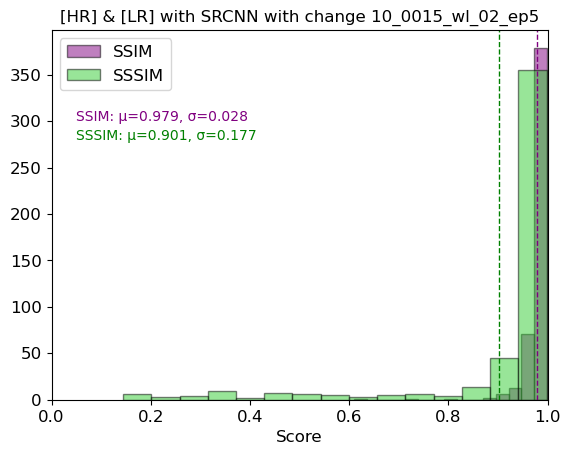

In [55]:
ssim_vals = combined_test_results_ssim['kmean_metric'].values
sssim_vals = combined_test_results_sssim['kmean_metric'].values

ssim_mean = np.mean(ssim_vals)
ssim_std = np.std(ssim_vals)
sssim_mean = np.mean(sssim_vals)
sssim_std = np.std(sssim_vals)

plt.figure()
plt.hist(ssim_vals, bins=15, alpha=0.5, color='purple', edgecolor='black', label='SSIM')
plt.hist(sssim_vals, bins=15, alpha=0.5, color='limegreen', edgecolor='black', label='SSSIM')

# 添加均值、方差文本
plt.text(0.05, 300, f'SSIM: μ={ssim_mean:.3f}, σ={ssim_std:.3f}', fontsize=10, color='purple')
plt.text(0.05, 280, f'SSSIM: μ={sssim_mean:.3f}, σ={sssim_std:.3f}', fontsize=10, color='green')

# 可选：标出均值所在位置的竖线
plt.axvline(ssim_mean, color='purple', linestyle='dashed', linewidth=1)
plt.axvline(sssim_mean, color='green', linestyle='dashed', linewidth=1)

plt.legend(fontsize=12)
plt.xlabel('Score', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(xmin=0, xmax=1)
plt.title("[HR] & [LR] with SRCNN with change "+change)
plt.savefig("result_plot/srcnn_ssim_"+change+".png")